In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from astropy import units
from astropy import constants as const


import seaborn as sns

sns.set(context="poster", font_scale=1.5)

import os
import glob

import dimensionalize_sedov

hbar     = const.hbar.cgs.value
k_b      = 1.380649e-16
m_proton = 1.672622e-24



pc       = units.pc.to(units.cm)
yr       = units.yr.to(units.s)
M_solar  = units.MsolMass.to(units.g)
gamma    = 5./3



:0: FutureWarning: IPython widgets are experimental and may change in the future.


checkpoint:  checkpoint_0099.dat
time:  94117.6768829 [yr]
zones:  1065
energy conserved to:  -9.47905779018e-11


<function __main__.plotter>

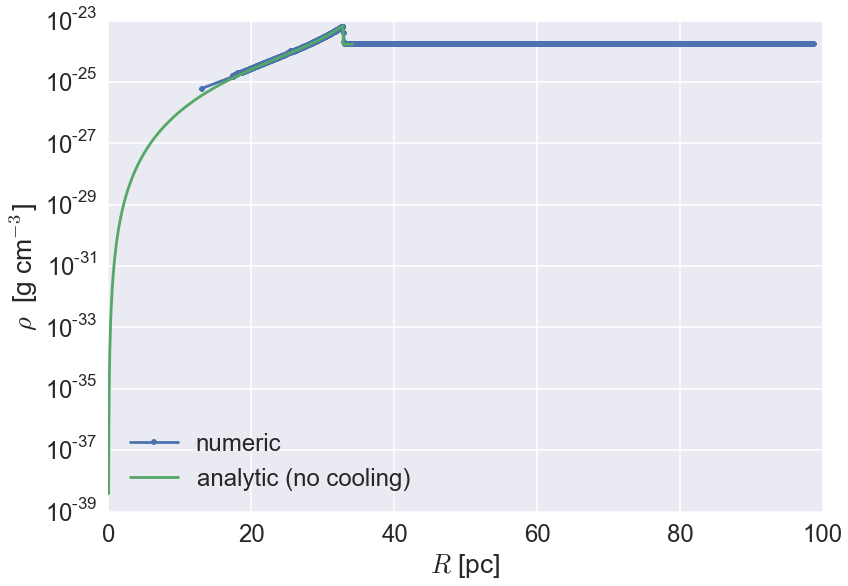

In [2]:
data_dir = ''
# data_dir = 'saved_runs/riemann/BC_old/hydro/1e5yr/'
# data_dir = 'saved_runs/riemann/BC_old/hydro_with_cooling/1e6yr/' 
# data_dir = 'saved_runs/riemann/BC_new/hydro/1e5yr/'
# data_dir = 'saved_runs/riemann/BC_new/hydro_with_cooling/1e5yr/'


checkpoint_filenames = glob.glob(data_dir + "checkpoint_*.dat")
# if os.path.exists(data_dir + "output.dat"):
#     checkpoint_filenames.append(data_dir + "output.dat")
num_checkpoints = len(checkpoint_filenames)
    
times = np.empty(num_checkpoints)
for k, checkpoint_filename in enumerate(checkpoint_filenames):
    f = open(checkpoint_filename, 'r')
    line = f.readline()
    times[k] = float(line.split()[3])
    f.close()


if os.path.exists(data_dir + "overview.dat"):
    f = open(data_dir + "overview.dat", "r")
    line = f.readline()
    metallicity = float(line.split()[1])

    line = f.readline()
    background_density = float(line.split()[2])
    
    line = f.readline()
    background_temperature = float(line.split()[2])
    f.close()
else:
    metallicity = .02
    background_density = m_proton
    background_temperature = 1e4
    
def calculate_mean_molecular_weight(X,Y,Z):
    mu = (2*X + .75*Y + .5*Z)**-1
    return mu   
Z = metallicity
Y = .23
X = 1 - Y - Z
mu = calculate_mean_molecular_weight(X, Y, Z)

def calc_mass(density, dV):
    mass = density * dV
    return mass

def calc_kinetic_energy(mass, velocity):
    E_kin = (1./2) * mass * velocity**2.
    return E_kin.sum()

def calc_internal_energy(mass, pressure, density):
    E_int = mass * (1./(gamma-1)) * pressure / density
    return E_int.sum()

E_int = np.empty(num_checkpoints)
E_kin = np.empty(num_checkpoints)
E_tot = np.empty(num_checkpoints)
M_tot = np.empty(num_checkpoints)
zones = np.empty(num_checkpoints)

#### PARSE DATAFILES INTO DATAFRAME
cols = ["Radius", "dR", "dV", "Density", "Pressure", "Velocity", "X", "Alpha", "Temperature", "Energy", "Entropy", "Mass", "M_int"]
cols_in   = cols[:-5]
cols_plot = cols[0:6] + cols[8:]

df = pd.DataFrame()
for k, checkpoint_filename in enumerate(checkpoint_filenames):
    array_tmp = np.loadtxt(checkpoint_filename)
    array_tmp = array_tmp[0:-1] # ignore inner + outer guard cells
    index     = pd.MultiIndex.from_product([k, range(array_tmp.shape[0])], names=["k","i"])
    df_tmp    = pd.DataFrame(array_tmp, columns=cols_in, index = index)
    
    df_tmp["Temperature"] = (df_tmp.Pressure / df_tmp.Density) * (mu * m_proton / k_b)
    df_tmp["Energy"] = (df_tmp.Pressure / df_tmp.Density) / (gamma-1)
    df_tmp["Entropy"] = 2.5 - \
        np.log( (df_tmp.Density/(mu * m_proton)) * (2*np.pi*hbar**2 / (mu * m_proton * k_b * df_tmp.Temperature))**1.5 )
    df_tmp["Mass"]  = calc_mass(df_tmp.Density, df_tmp.dV)
    df_tmp["M_int"] = df_tmp.Mass.cumsum()
    E_kin[k] = calc_kinetic_energy(df_tmp.Mass, df_tmp.Velocity)
    E_int[k] = calc_internal_energy(df_tmp.Mass, df_tmp.Pressure, df_tmp.Density)
    E_tot[k] = E_kin[k] + E_int[k]
    M_tot[k] = df_tmp.M_int[-1]
    zones[k] = df_tmp.shape[0]
    
    df = pd.concat([df, df_tmp])
df.Radius /= pc
df.Mass /= M_solar
df.M_int /= M_solar


#### PLOT ####
label_dict = {"Radius"      :"$R$ [pc]", 
              "Velocity"    : r"$U$ [cm s$^{-1}$]",
              "Density"     : r"$\rho$  [g cm$^{-3}$]",
              "Temperature" : r"$T$ [K]",
              "Mass"        : r"$M$ [$M_\odot$]",
              "M_int"       : r"$M_\mathrm{int}$ [$M_\odot$]",
              "C_ad"        : r"$C_{ad}$ [cm s$^{-1}$]",
              "Energy"      : r"$E_{int}$ [erg g$^{-1}$]",
              "Pressure"    : r"$P$ [dyne cm$^{-2}$]",
              "Entropy"     : r"$S$ [$k_B$ / particle]",
              "M_int"       : r"$M_{int}$ [$M_\odot$]",
              "dR"          : r"$\Delta R$ [cm]",
              "dV"          : r"$\Delta V$ [cm$^3$]",
              "X"           : r"$X$ (passive scalar)",
              "Alpha"       : r"$\alpha$ (turbulence strength)"
             }


def plotter(y_axis_variable = "Density",
            Radius_as_x_axis = True,
            with_Sedov = True,
            outer_limit_log = 2, 
            checkpoint_index = num_checkpoints-1):
        
    df_tmp = df.loc[checkpoint_index]
    
    checkpoint_filename = checkpoint_filenames[checkpoint_index]
    time = times[checkpoint_index]

    print("checkpoint: ", checkpoint_filename)
    print("time: ", time / yr, "[yr]")

    print("zones: ", df_tmp.shape[0])
    print("energy conserved to: ", (E_tot[checkpoint_index] - E_tot[0]) / E_tot[0])
    
    if Radius_as_x_axis:
        x_axis_variable = "Radius"
        plt.xlim((0,10**outer_limit_log))
    else:
        x_axis_variable = "M_int"
    
    marker = "."
    plt.plot(df_tmp[x_axis_variable], df_tmp[y_axis_variable], marker=marker, label="numeric")  
    
    if with_Sedov is True:
        sedov_cols = ["Radius", "Velocity", "Density", "Temperature", "C_ad", "Energy", "Pressure", "Entropy", "Mass"]
        if y_axis_variable in sedov_cols:
            sedov = dimensionalize_sedov.main(time, metallicity=metallicity, 
                                                    background_density=background_density,
                                                    background_temperature=background_temperature)
            sedov = np.array(sedov).transpose()
            df_sedov = pd.DataFrame.from_records(sedov, 
                                                 columns=sedov_cols)
            df_sedov.Radius /= pc
            df_sedov.Mass /= M_solar
            df_sedov["M_int"] = df_sedov.Mass.cumsum()

            plt.plot(df_sedov[x_axis_variable], df_sedov[y_axis_variable], label="analytic (no cooling)")  
        
    plt.xlabel(label_dict[x_axis_variable])
    plt.ylabel(label_dict[y_axis_variable])
    plt.yscale("log")
    plt.legend(loc="best")




interact(plotter,
        outer_limit_log = (-1., 2.),
        checkpoint_index=(0, num_checkpoints-1),
        y_axis_variable = cols_plot,
        Radius_as_x_axis = True)

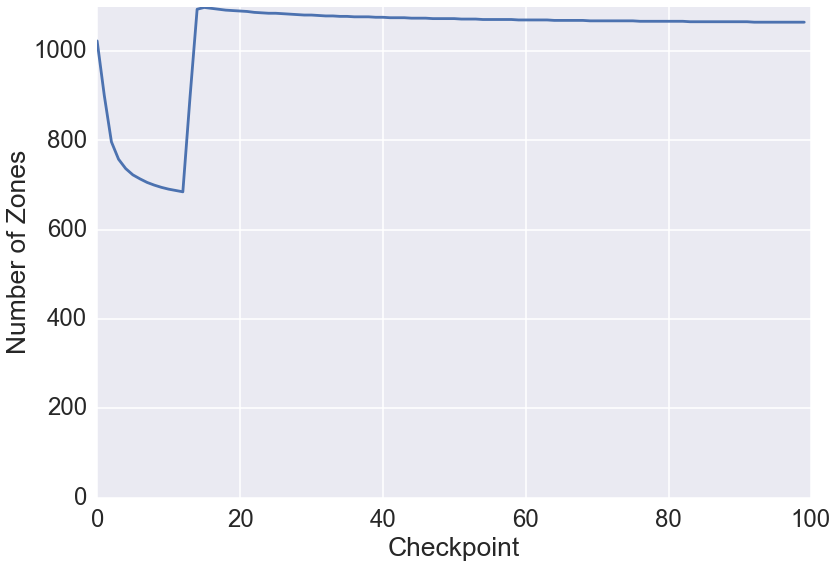

In [3]:
plt.plot(zones)
plt.ylim(ymin=0)
plt.ylabel("Number of Zones")
plt.xlabel("Checkpoint")

[  1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51   1.41509894e+51   1.41509894e+51
   1.41509894e+51   1.41509894e+51

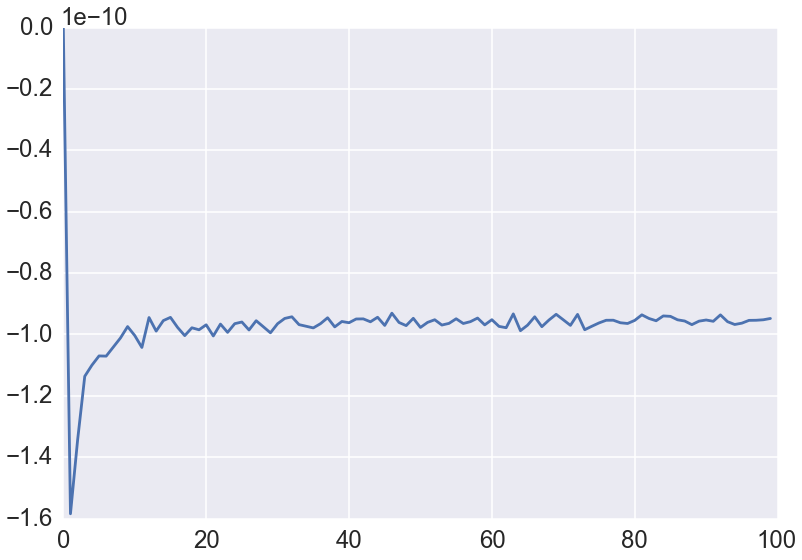

In [4]:
E_err = (E_tot - E_tot[0]) / E_tot[0]
print(E_tot)
# plt.plot(abs(E_err))
# plt.yscale("log")
plt.plot(E_err)
